# Load previous results

In [1]:
import pickle
with open("results.pkl", "rb") as fh:
    final_results = pickle.load(fh)

# Loading the Corpus

In [2]:
from corpora import hulth, scopus, semeval, kp20k
from importlib import reload

In [3]:
corpus_name = "semeval"

In [4]:
if corpus_name == "scopus":
    df = scopus.load()
elif corpus_name == "hulth":
    df = hulth.load()
elif corpus_name == "semeval":
    df = semeval.load()
elif corpus_name == "kp20k":
    df = kp20k.load()
    df = df.reset_index()
    df = df[:100000]
else:
    raise Exception("no corpus loaded")

# Removing documents with no Ground Truth keywords that are also in the text

In [5]:
def kwds_in_text(kwds, text):
    return [kw for kw in kwds if kw.lower() in text.lower()]

actual_kwds = [[kw.lower() for kw in r["keywords"].split("; ")] for idx, r in df.iterrows()]
has_kwds_despite_kw_removal = [len(kwds_in_text(kwds, text)) > 0 for kwds, text in zip(actual_kwds, df["abstract"])]
df = df[has_kwds_despite_kw_removal]

# TFIDF keywords

In [6]:
from tfidf_KW_extraction import Tfidf_Pos_keywords
tfidf = Tfidf_Pos_keywords(df["abstract"])

# Fuzzy Matching

In [7]:
from fuzzywuzzy import fuzz
import numpy as np

def issimilar(a, b, t=80):
    '''
    Returns `True` if the strings a and b are sufficiently similar and
    `False` otherwise.
    '''
    if fuzz.token_sort_ratio(a, b) > t:
        return True
    else:
        return False
    
def fuzzy_is_in(candidate, kwds, t=80):
    return np.any([issimilar(candidate, kw, t) for kw in kwds])

# Keyword Extraction Tools

In [8]:
fh = open("corpora/stoplist.txt")
stopwords = fh.readlines()
fh.close()
stopwords = " ".join(stopwords).split("\n ")

In [9]:
from gensim.summarization import keywords as textrank_keywords
from jgtextrank import keywords_extraction as textrank_keywords_jg
from rake_nltk import Rake
from rake_nltk import Metric
from itertools import islice

def textrank_gensim(text, num_kwds=None, scores=False):
    try:
        results = textrank_keywords(text, ratio=1., scores=True)
    except ZeroDivisionError:
        return []
    
    if scores == False:
        results = [kw for kw, scores in results]
    return list(islice(results, num_kwds))

def textrank(text, num_kwds=None, scores=False):
    try:
        results, _ = textrank_keywords_jg(text, window=2, directed=False, stop_words=stopwords, workers=1)
    except KeyError:
        text = ''.join([i if ord(i) < 128 else ' ' for i in text]) # remove non-ascii characters
        results, _ = textrank_keywords_jg(text, window=2, directed=False, stop_words=stopwords, workers=1)
        
    if scores == False:
        results = [kw for kw, scores in results]
    return list(islice(results, num_kwds))

def rake(text, num_kwds=None, scores=False):
    r = Rake(stopwords=stopwords, punctuations=". , ? ! - : ; \" \' ( ) [ ]".split(), language='english')
    r.extract_keywords_from_text(text)
    if scores == True:
        results = r.get_ranked_phrases_with_scores()
        results = [(kw, score) for score, kw in results]
    else:
        results = r.get_ranked_phrases()
    return list(islice(results, num_kwds))

# Function for calculating precision, recall and F1

In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd

def kwd_metrics(extracted=None, actual=None, fuzzy=True, t=80):
    extracted = list(map(lambda s: s.lower(), extracted))
    actual = list(map(lambda s: s.lower(), actual))

    assert t >=0 and t <=100, "t must be 0 <= t <= 100"

    if t==100: # not fuzzy
        all_kwds = set(actual).union(extracted)
        y_true = [kw in actual for kw in all_kwds]
        y_pred = [kw in extracted for kw in all_kwds]
    else: # go fuzzy
        # get rid of extracted kwds that are similar to kwds in actual
        extracted_no_dup = [e for e in extracted if not fuzzy_is_in(e, actual, t=t)]
        all_kwds = set(actual).union(extracted_no_dup)
        y_true = [fuzzy_is_in(kw, actual, t=t) for kw in all_kwds]
        y_pred = [fuzzy_is_in(kw, extracted, t=t) for kw in all_kwds]
    
    precision = precision_score(y_true, y_pred, average="binary")
    recall = recall_score(y_true, y_pred, average="binary")
    f1 = f1_score(y_true, y_pred, average="binary")
        
    return {
        'precision': precision, 
        'recall': recall,
        'f1': f1
    }

# Benchmark

In [11]:
from tqdm import tqdm
from collections import defaultdict
from multiprocessing import Pool, cpu_count
from concurrent.futures import ProcessPoolExecutor
from functools import partial

def kw_extraction(text_iter, extractor, num_kwds=None, multi_threaded=False):
    my_extractor = partial(extractor, num_kwds=num_kwds)
    if multi_threaded:
        with ProcessPoolExecutor(max_workers=8) as p:
            kwds = p.map(my_extractor, text_iter)
    else:
        kwds = map(my_extractor, text_iter)
    return kwds

def assess_extractor(extractor, df, num_kwds=None, t=80, kw_removal=True):
    """
    """
    text_iter = [r["abstract"] for idx, r in df.iterrows()]
    
    extr_kwds = kw_extraction(text_iter, extractor, num_kwds=num_kwds)
    
    actual_kwds = [[kw.lower() for kw in r["keywords"].split("; ")] for idx, r in df.iterrows()]
    if kw_removal:
        actual_kwds = [kwds_in_text(kwds, text) for kwds, text in zip(actual_kwds, df["abstract"])]
        
    scores = pd.DataFrame(columns=('precision', 'recall', 'f1'))
    for idx, a, e in zip(df.index, actual_kwds, extr_kwds):
        scores.loc[idx] = kwd_metrics(extracted=e, actual=a, t=t)
    return scores

# Train the Tfidf Vectorizer

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words="english", smooth_idf=True).fit(df["abstract"])

In [13]:
import numpy as np
def tfidf_scores(document, vectorizer):
    '''
    returns the raw tfidf scores of document passed.
    '''
    transformed_doc = vectorizer.transform([document]).toarray()[0]
    tfidf_scores = {}

    for w in document.split():
        try:
            word_id = vectorizer.vocabulary_[w]
            tfidf_scores[w] = transformed_doc[word_id]
        except KeyError:
            pass
    return tfidf_scores

def weight_keywords(kwds, scores):
    '''
    weights the keywords in `kwds` with the tfidf scores provided
    in `scores`. the returned list of tuples is sorted. the highest
    scoring keyword comes first.
    '''
    kwd_scores = []
    for kwd in kwds:
        tokens = kwd.split()
        cum_score = 0
        token_count = 0
        for token in tokens:
            if token in scores:
                cum_score += scores[token]
                token_count += 1
        if token_count > 0:
            kwd_scores.append(cum_score * (1 - .1 * token_count))
        else:
            kwd_scores.append(0)        
            
    return sorted([(kwd, score) for kwd, score in zip(kwds, kwd_scores)], 
        key=lambda x: x[1], reverse=True)

def rank_keywords(document, extr=None, vectorizer=None, num_kwds=None, scores=False):
    '''
    produces a sorted list of keywords produced by `extr` on the
    document with index `idx`.
    '''
    kwds = extr(document, num_kwds=None, scores=False)
    results = tfidf_scores(document, vectorizer)
    results = weight_keywords(kwds, results)
    if scores == False:
        results = [kw for kw, scores in results]    
    return list(islice(results, num_kwds))

In [14]:
def tfidfify(extr, vectorizer):
    """
    Changes the ranking of a keyword extractor to a tfidf-based one.
    """
    return partial(rank_keywords, extr=extr, vectorizer=vectorizer) 

In [15]:
tfidfed_rake = tfidfify(rake, vectorizer)
tfidfed_textrank = tfidfify(textrank, vectorizer)

# Frankenrake's Textrank

In [16]:
from itertools import chain

def tfidfed_frankenrake(text, num_kwds=None, scores=False):
    def frankenrake(text, num_kwds=None, scores=False):
        kwds = list({kw for kw in chain(rake(text), textrank(text))})
        return kwds

    tfidfed = tfidfify(frankenrake, vectorizer)
    return list(islice(tfidfed(text, scores=scores), num_kwds))

# Run Evaluation

### One job at a time

In [17]:
"""
from collections import defaultdict
kw_threshholds = range(1, 21, 1)

scores = {i: {"textrank": None, "rake": None, "tfidfed_textrank": None, "tfidfed_rake": None} 
    for i in kw_threshholds}

for i in tqdm(kw_threshholds):
    for extr_name, extr in zip(("textrank", "rake", "tfidfed_textrank", "tfidfed_rake", "frankenrake", "tfidf"), \
            (textrank, rake, tfidfed_textrank, tfidfed_rake, tfidfed_frankenrake, tfidf)):
        scores[i][extr_name] = assess_extractor(extr, df, num_kwds=i, t=100, kw_removal=True)
"""

'\nfrom collections import defaultdict\nkw_threshholds = range(1, 21, 1)\n\nscores = {i: {"textrank": None, "rake": None, "tfidfed_textrank": None, "tfidfed_rake": None} \n    for i in kw_threshholds}\n\nfor i in tqdm(kw_threshholds):\n    for extr_name, extr in zip(("textrank", "rake", "tfidfed_textrank", "tfidfed_rake", "frankenrake", "tfidf"),             (textrank, rake, tfidfed_textrank, tfidfed_rake, tfidfed_frankenrake, tfidf)):\n        scores[i][extr_name] = assess_extractor(extr, df, num_kwds=i, t=100, kw_removal=True)\n'

# multiple jobs at a time

In [18]:
def partial_assess_extractor(i):
    scores = {"textrank": None, "rake": None, "tfidfed_textrank": None, "tfidfed_rake": None} 

    for extr_name, extr in tqdm(zip(("textrank", "rake", "tfidfed_textrank", "tfidfed_rake", "frankenrake", "tfidf"), \
            (textrank, rake, tfidfed_textrank, tfidfed_rake, tfidfed_frankenrake, tfidf))):
        scores[extr_name] = assess_extractor(extr, df, num_kwds=i, t=100, kw_removal=True)
    return (i, scores)

In [19]:
%%time
from concurrent.futures import ProcessPoolExecutor

with ProcessPoolExecutor(max_workers=32) as p:
    results = p.map(partial_assess_extractor, range(1, 21, 1))
results = list(results)

6it [05:03, 50.54s/it]
6it [05:03, 50.58s/it]
6it [05:03, 50.59s/it]
6it [05:03, 50.60s/it]
6it [05:03, 50.61s/it]
6it [05:03, 50.64s/it]
6it [05:04, 50.68s/it]
6it [05:04, 50.72s/it]
6it [05:04, 50.75s/it]
6it [05:04, 50.76s/it]
6it [05:04, 50.75s/it]
6it [05:04, 50.79s/it]
6it [05:04, 50.80s/it]
6it [05:04, 50.80s/it]
6it [05:05, 50.87s/it]
6it [05:05, 50.88s/it]
6it [05:05, 50.88s/it]
6it [05:05, 50.89s/it]
6it [05:05, 50.92s/it]
6it [05:05, 50.96s/it]


CPU times: user 182 ms, sys: 1.73 s, total: 1.92 s
Wall time: 5min 6s


In [20]:
kw_threshholds = range(1, 21, 1)
scores = {i: {"textrank": None, "rake": None, "tfidfed_textrank": None, "tfidfed_rake": None} 
    for i in kw_threshholds}

for r in results:
    for k, v in r[1].items():
        scores[r[0]][k] = v
        
final_results[corpus_name] = scores

# multpile jobs end

# Store results

In [21]:
import pickle
with open("results.pkl", "wb") as fh:
    pickle.dump(final_results, fh)

In [22]:
from collections import namedtuple

def get_data(algorithm, corpus):
    Retrieval_scores = namedtuple("Retrieval_scores", "p r f a".split())
    scores = final_results[corpus]
    
    precision = [scores[i][algorithm]["precision"].mean() for i in kw_threshholds]
    recall = [scores[i][algorithm]["recall"].mean() for i in kw_threshholds]
    f1 = [scores[i][algorithm]["f1"].mean() for i in kw_threshholds]
    return Retrieval_scores(precision, recall, f1, algorithm)

X = get_data("tfidf", "scopus")
Y = get_data("rake", "scopus")

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

plt.rcParams["font.family"] = 'serif'

colors = sns.color_palette("Set1", 6)
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(kw_threshholds, X.p, ':v', c=colors[0], label=f"$\pi$ {X.a}")
ax.plot(kw_threshholds, X.r, ':D', c=colors[1], label=f"$\\rho$ {X.a}")
ax.plot(kw_threshholds, X.f, ':d', c=colors[2], label=f"F1 {X.a}")

ax.plot(kw_threshholds, Y.p, '-v', c=colors[0], alpha=.4, label=f"$\pi$ {Y.a}")
ax.plot(kw_threshholds, Y.r, '-D', c=colors[1], alpha=.4, label=f"$\\rho$ {Y.a}")
ax.plot(kw_threshholds, Y.f, '-d', c=colors[2], alpha=.4, label=f"F1 {Y.a}")

ax.set_ylim(0.0, .5)
ax.set_xlabel('Number of Keyphrases', fontsize=16)
ax.set_ylabel('Score', fontsize=16)

ax.legend(fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#ax.set_facecolor("white")

for spine in plt.gca().spines.values():
    spine.set_visible(True)

#plt.title(f"{corpus_name} without Fuzzy Matching + KW Removal", fontsize=18)

plt.xticks(kw_threshholds)
plt.show()

<Figure size 1000x800 with 1 Axes>

# Enlightning Tools

In [24]:
idx = np.random.choice(df.index)
extractor = rake
num_kwds = 10

text = df.loc[idx, "abstract"]
actual = df.loc[idx, "keywords"].split("; ")
actual = kwds_in_text(actual, text)
actual = list(map(lambda s: s.lower(), actual))

extracted = extractor(df.loc[idx, "abstract"], num_kwds=num_kwds)
extracted = list(map(lambda s: s.lower(), extracted))

all_kwds = set(actual).union(extracted)
y_true = [kw in actual for kw in all_kwds]
y_pred = [kw in extracted for kw in all_kwds]

precision = precision_score(y_true, y_pred, average="binary")
recall = recall_score(y_true, y_pred, average="binary")
f1 = f1_score(y_true, y_pred, average="binary")

print("ABSTRACT:\n", df.loc[idx, "abstract"], end="\n\n")
print("ACTUAL KEYWORDS:\n", ", ".join(actual), end="\n\n")
print("EXTRACTED:\n", ", ".join(extracted), end="\n\n")
print(f"PRECISION: {precision}\nRECALL: {recall}\nF1: {f1}")

ABSTRACT:
 We prove the uniqueness of the supersymmetric Salam–Sezgin (Minkowski)4×S2 ground state among all non-singular solutions with a four-dimensional Poincaré, de Sitter or anti-de Sitter symmetry. We construct the most general solutions with an axial symmetry in the two-dimensional internal space, and show that included amongst these is a family that is non-singular away from a conical defect at one pole of a distorted 2-sphere. These solutions admit the interpretation of 3-branes with negative tension.


ACTUAL KEYWORDS:
 non-singular solutions with a four-dimensional poincaré, de sitter or anti-de sitter symmetry, axial symmetry in the two-dimensional internal space,, 3-branes with negative tension

EXTRACTED:
 4 × s2 ground state, supersymmetric salam – sezgin, dimensional internal space, de sitter symmetry, de sitter, dimensional poincaré, axial symmetry, solutions admit, negative tension, general solutions

PRECISION: 0.0
RECALL: 0.0
F1: 0.0


In [25]:
def plot_ranking_stats(num_kwds, algorithm, metric):
    y = scores[num_kwds][algorithm].sort_values(by=metric)[::-1][metric]
    mean = scores[num_kwds][algorithm][metric].mean()

    fig, ax = plt.subplots(figsize=(16,9))
    ax.plot(range(y.values.shape[0]), y.values)
    ax.axhline(mean, color="red")
    ax.set_xlabel("rank")
    ax.set_ylabel("score")
    ax.set_title(f"{metric}@{num_kwds} Keywords using {algorithm}")
    plt.show()

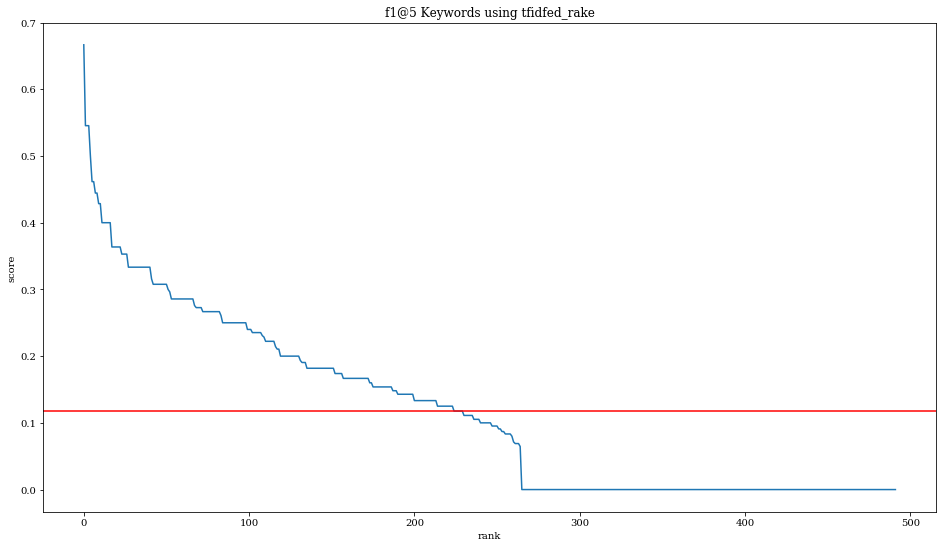

In [26]:
plot_ranking_stats(5, "tfidfed_rake", "f1")

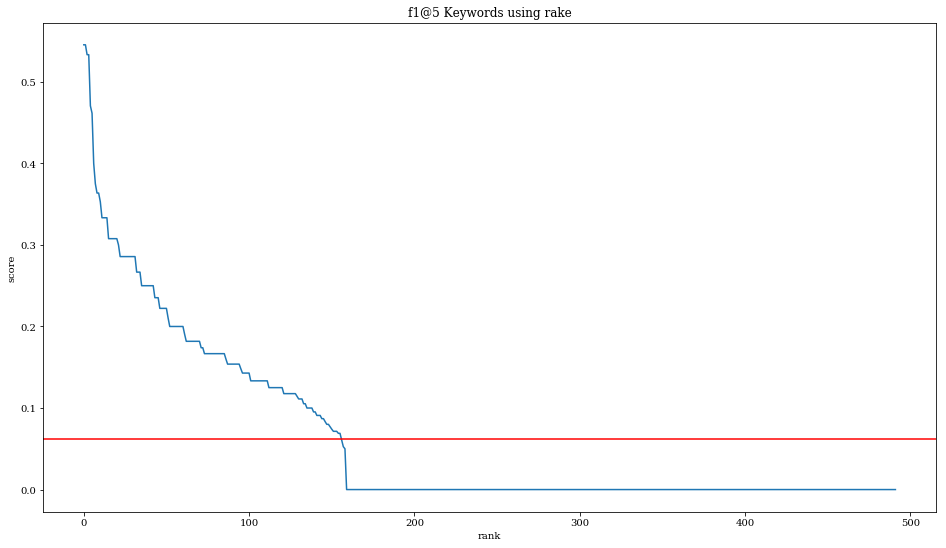

In [27]:
plot_ranking_stats(5, "rake", "f1")